## Data Preprocessing

In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, confusion_matrix,roc_auc_score,recall_score,f1_score, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential

from pyAudioAnalysis import ShortTermFeatures
import opensmile
import xgboost as xgb

from pydub import AudioSegment
import math
import os

#### Load in output labels and visualize class distribution

In [8]:
# load in output labels
train_csv_file = pd.read_csv('./data/labels/train_split_Depression_AVEC2017.csv')[["Participant_ID", "PHQ8_Binary"]]
dev_csv_file = pd.read_csv('./data/labels/dev_split_Depression_AVEC2017.csv')[["Participant_ID", "PHQ8_Binary"]]
test_csv_file = pd.read_csv('./data/labels/full_test_split.csv')[["Participant_ID", "PHQ_Binary"]].rename(columns={"PHQ_Binary":"PHQ8_Binary"})
all_labels = pd.concat([train_csv_file, dev_csv_file, test_csv_file]).reset_index().drop(columns=["index"])
all_labels.head()

,Participant_ID,PHQ8_Binary
0,303,0
1,304,0
2,305,0
3,310,0
4,312,0


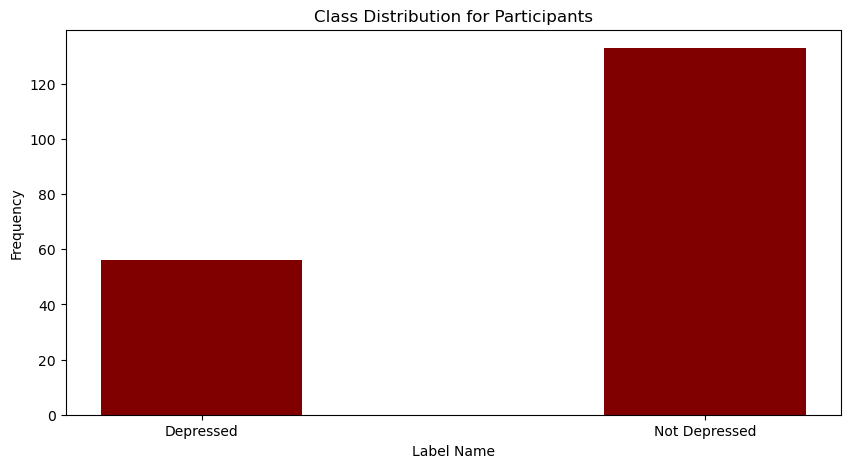

In [9]:
# number of participants labelled as "depressed" vs "nondepressed"

# get the label names and their frequency
all_labels["output_label"] = np.array(["Depressed" if x == 1 else "Not Depressed" for x in all_labels["PHQ8_Binary"]])
x_vals, y_vals = np.unique(all_labels["output_label"], return_counts = True)

# set up figure
fig = plt.figure(figsize = (10, 5))

# create bar plot
plt.bar(x_vals, y_vals, color ='maroon', width=0.4)

# make plot look nice
plt.xlabel("Label Name")
plt.ylabel("Frequency")
plt.title("Class Distribution for Participants")
plt.show()

#### Splice audio into shorter, equal lengthed sample clips and visualize the class distribution of the samples

In [10]:
# function that reads in the wav file and returns a list of the shorter clips
def split_audio_into_segments(input_file, segment_length_ms=10000, output_dir="segments"):
    """
    Split an audio file into equal segments of specified length.
    
    Parameters:
    input_file (str): Path to input audio file
    segment_length_ms (int): Length of each segment in milliseconds (default: 10000ms = 10s)
    output_dir (str): Directory to save the segments (default: 'segments')
    
    Returns:
    list: List of paths to the created segment files
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Load the audio file
    audio = AudioSegment.from_file(input_file)
    
    # Calculate duration and number of segments
    duration_ms = len(audio)
    num_segments = math.floor(duration_ms / segment_length_ms)
    
    segment_files = []
    
    # Split the audio into segments
    for i in range(num_segments):
        # Calculate start and end times for each segment
        start_time = i * segment_length_ms
        end_time = min((i + 1) * segment_length_ms, duration_ms)
        
        # Extract segment
        segment = audio[start_time:end_time]
        
        # Generate output filename
        filename = os.path.splitext(os.path.basename(input_file))[0]
        output_path = os.path.join(output_dir, f"{filename}_segment_{i+1}.mp3")
        
        # Export segment
        segment.export(output_path, format="mp3")
        segment_files.append(output_path)
        
    return segment_files

In [11]:
participants_col = []
audio_col = []
label_col = []

dir_name = '../depression-detect/data/interim'

# iterate through wav files in dir_name and create a segmented wav_file
for folder in os.listdir(dir_name):
    if len(folder) == 4:
        folder_path = os.path.join(dir_name, folder)
        participant_num = np.int64(folder[1:])
        label = all_labels[all_labels["Participant_ID"] == participant_num].reset_index()["output_label"][0]
        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                clips = split_audio_into_segments(file_path)
                audio_col += clips
                label_col += [label for i in range(len(clips))]
                participants_col += [participant_num for i in range(len(clips))]

full_df = pd.DataFrame(
    data = {
        "Participant Number" : participants_col,
        "Audio Path": audio_col,
        "Output Label": label_col}
)
full_df.head()

,Participant Number,Audio Path,Output Label
0,304,segments/P304_no_silence_segment_1.mp3,Not Depressed
1,304,segments/P304_no_silence_segment_2.mp3,Not Depressed
2,304,segments/P304_no_silence_segment_3.mp3,Not Depressed
3,304,segments/P304_no_silence_segment_4.mp3,Not Depressed
4,304,segments/P304_no_silence_segment_5.mp3,Not Depressed


In [14]:
def split_data_by_participant(df, train_size=0.8, val_size=0.1, random_state=42):
    """
    Split data into train, validation, and test sets based on participant IDs.
    
    Args:
        df: pandas DataFrame containing the data
        train_size: proportion of participants for training (default 0.8)
        val_size: proportion of participants for validation (default 0.1)
        random_state: random seed for reproducibility
        
    Returns:
        train_df, val_df, test_df: DataFrames containing the split data
    """
    # Get unique participant IDs
    unique_participants = df['Participant Number'].unique()
    
    # Shuffle participant IDs
    np.random.seed(random_state)
    np.random.shuffle(unique_participants)
    
    # Calculate number of participants for each split
    n_participants = len(unique_participants)
    n_train = int(n_participants * train_size)
    n_val = int(n_participants * val_size)
    
    # Split participant IDs into train, val, test
    train_participants = unique_participants[:n_train]
    val_participants = unique_participants[n_train:n_train + n_val]
    test_participants = unique_participants[n_train + n_val:]
    
    # Split data based on participant IDs
    train_df = df[df['Participant Number'].isin(train_participants)]
    val_df = df[df['Participant Number'].isin(val_participants)]
    test_df = df[df['Participant Number'].isin(test_participants)]
    
    # Print split information
    print(f"Train set: {len(train_participants)} participants ({len(train_df)} samples)")
    print(f"Validation set: {len(val_participants)} participants ({len(val_df)} samples)")
    print(f"Test set: {len(test_participants)} participants ({len(test_df)} samples)")
    
    return train_df, val_df, test_df

In [39]:
# Define splits
split = (0.8, 0.1, 0.1)

# Split the data by participant
train_data, val_data, test_data = split_data_by_participant(full_df, train_size=0.8, val_size=0.1, random_state=38)

Train set: 128 participants (7244 samples)
Validation set: 16 participants (883 samples)
Test set: 16 participants (918 samples)



Label Distribution:

Training Set:
Output Label
Not Depressed    68.5
Depressed        31.5
Name: proportion, dtype: float64 %

Validation Set:
Output Label
Not Depressed    65.3
Depressed        34.7
Name: proportion, dtype: float64 %

Test Set:
Output Label
Not Depressed    70.0
Depressed        30.0
Name: proportion, dtype: float64 %


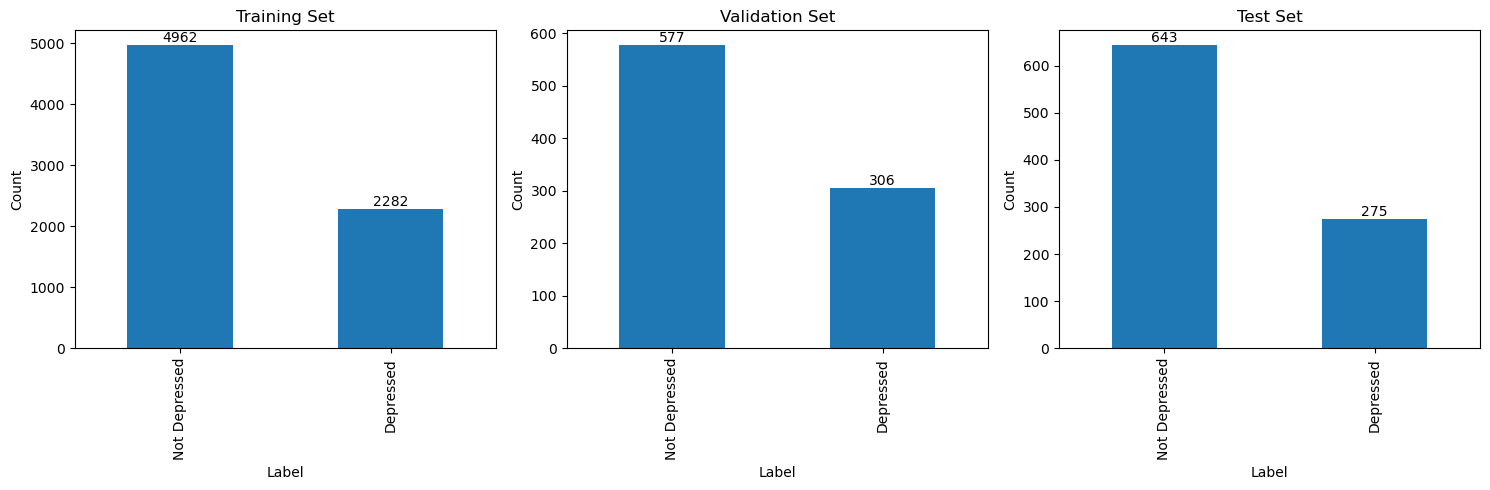

In [40]:
def visualize_label_distribution(train_df, val_df, test_df, label_col='Output Label'):
    """
    Create a bar plot showing the distribution of labels in train, validation, and test sets.
    
    Args:
        train_df, val_df, test_df: DataFrames containing the split data
        label_col: name of the column containing labels (default 'PHQ8_Binary')
    """
    # Calculate value counts for each dataset
    train_counts = train_df[label_col].value_counts()
    val_counts = val_df[label_col].value_counts()
    test_counts = test_df[label_col].value_counts()
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot for training set
    train_counts.plot(kind='bar', ax=ax1, title='Training Set')
    ax1.set_xlabel('Label')
    ax1.set_ylabel('Count')
    for i, v in enumerate(train_counts):
        ax1.text(i, v, str(v), ha='center', va='bottom')
    
    # Plot for validation set
    val_counts.plot(kind='bar', ax=ax2, title='Validation Set')
    ax2.set_xlabel('Label')
    ax2.set_ylabel('Count')
    for i, v in enumerate(val_counts):
        ax2.text(i, v, str(v), ha='center', va='bottom')
    
    # Plot for test set
    test_counts.plot(kind='bar', ax=ax3, title='Test Set')
    ax3.set_xlabel('Label')
    ax3.set_ylabel('Count')
    for i, v in enumerate(test_counts):
        ax3.text(i, v, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Print percentages
    print("\nLabel Distribution:")
    print("\nTraining Set:")
    print(train_df[label_col].value_counts(normalize=True).round(3) * 100, "%")
    print("\nValidation Set:")
    print(val_df[label_col].value_counts(normalize=True).round(3) * 100, "%")
    print("\nTest Set:")
    print(test_df[label_col].value_counts(normalize=True).round(3) * 100, "%")

# Call the visualization function
visualize_label_distribution(train_data, val_data, test_data)

#### Now we have our data

In [46]:
# save the dataframes
train_data.to_csv("train_data")
val_data.to_csv("val_data")
test_data.to_csv("test_data")

In [2]:
# load in dataframes
train_data = pd.read_csv("train_data")
val_data = pd.read_csv("val_data")
test_data = pd.read_csv("test_data")

# drop the index column
train_data.drop(columns=["Unnamed: 0"], inplace=True)
val_data.drop(columns=["Unnamed: 0"], inplace=True)
test_data.drop(columns=["Unnamed: 0"], inplace=True)

In [3]:
train_data.head()

,Participant Number,Audio Path,Output Label
0,304,segments/P304_no_silence_segment_1.mp3,Not Depressed
1,304,segments/P304_no_silence_segment_2.mp3,Not Depressed
2,304,segments/P304_no_silence_segment_3.mp3,Not Depressed
3,304,segments/P304_no_silence_segment_4.mp3,Not Depressed
4,304,segments/P304_no_silence_segment_5.mp3,Not Depressed
